<a href="https://colab.research.google.com/github/mugilan0606/Dog-Breed-Prediction/blob/main/Dog_Breed_Prediction_using_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from glob import glob

dog_files = np.array(glob("drive/MyDrive/dogImages/*/*/*"))
print('There are %d total dog images.' % len(dog_files))

There are 8369 total dog images.


In [ ]:
import os
from torchvision import datasets, transforms
import torch

train_dir = 'drive/MyDrive/dogImages/train/'
test_dir = 'drive/MyDrive/dogImages/test/'
valid_dir = 'drive/MyDrive/dogImages/valid/'

batch_size = 20
valid_size = 0.1

data_transform= transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_transform_train= transforms.Compose([transforms.RandomRotation(15),
                                     transforms.RandomResizedCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform_train)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = train_data.classes

print('Number of training images: ', len(train_data))
print('Number of test images: ', len(test_data))
print('Number of dog breeds classes: ', len(classes))

Number of training images:  6680
Number of test images:  854
Number of dog breeds classes:  133


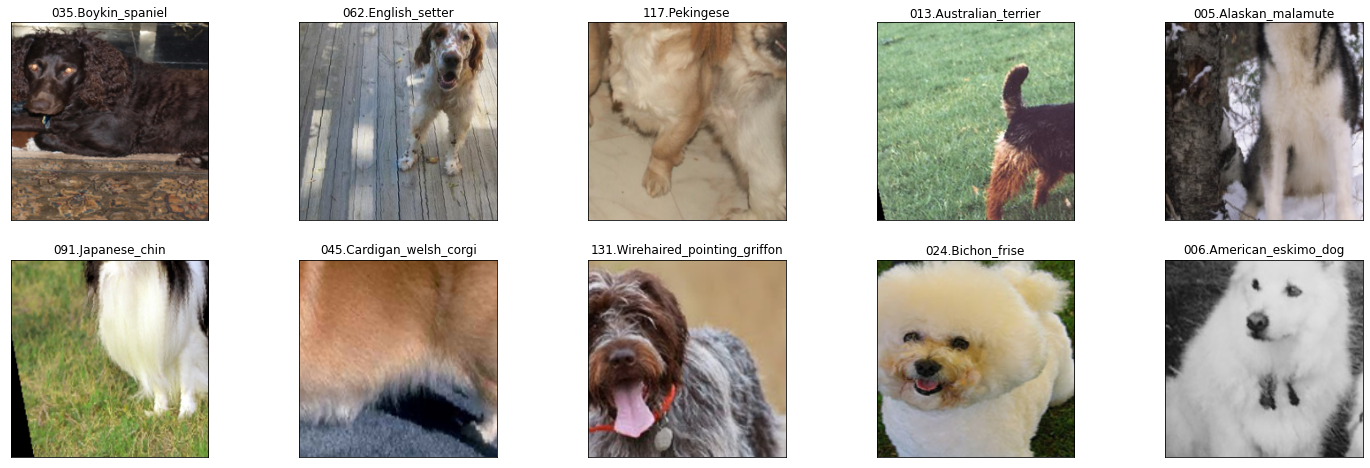

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(image):
    img = image / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))  

dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images.numpy() 

fig = plt.figure(figsize=(25, 8))

for i in np.arange(10):
    ax = fig.add_subplot(2, 10/2, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])



In [ ]:
import torchvision.models as models
import torch.nn as nn
import numpy as np

model_transfer = models.resnet50(pretrained=True)

print(model_transfer)

for param in model_transfer.parameters():
    param.requires_grad = False
    
n_inp = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(n_inp, 133)

#use_cuda = torch.cuda.is_available()
#print(use_cuda)
#if use_cuda:
#    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()

lr = 0.001
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss
            
    return model

n_epochs = 30

model_transfer = train(n_epochs, train_loader, valid_loader, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.822800 	Validation Loss: 4.675391
Validation loss decreased (inf --> 4.675391).  Saving model ...
Epoch: 2 	Training Loss: 4.607912 	Validation Loss: 4.455468
Validation loss decreased (4.675391 --> 4.455468).  Saving model ...
Epoch: 3 	Training Loss: 4.419758 	Validation Loss: 4.250667
Validation loss decreased (4.455468 --> 4.250667).  Saving model ...
Epoch: 4 	Training Loss: 4.245161 	Validation Loss: 4.044512
Validation loss decreased (4.250667 --> 4.044512).  Saving model ...
Epoch: 5 	Training Loss: 4.078873 	Validation Loss: 3.878345
Validation loss decreased (4.044512 --> 3.878345).  Saving model ...
Epoch: 6 	Training Loss: 3.916755 	Validation Loss: 3.700389
Validation loss decreased (3.878345 --> 3.700389).  Saving model ...
Epoch: 7 	Training Loss: 3.774131 	Validation Loss: 3.528542
Validation loss decreased (3.700389 --> 3.528542).  Saving model ...
Epoch: 8 	Training Loss: 3.618819 	Validation Loss: 3.364530
Validation loss decreased (3.52854

In [ ]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [ ]:
def test(test_loader, model, criterion, use_cuda):

    test_loss = 0.0
    correct = 0.0
    total = 0.0

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    return test_loss, correct, total


test_loss, correct, total = test(test_loader, model_transfer, criterion_transfer, use_cuda)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

Test Loss: 1.330525


Test Accuracy: 77% (660/854)


In [ ]:
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True

class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    global model_transfer
    image = Image.open(img_path).convert('RGB')
    image = data_transform(image).unsqueeze_(0)
    if use_cuda:
        image = image.cuda()
        model_transfer = model_transfer.cuda()
    model_transfer.eval()
    idx = torch.argmax(model_transfer(image))
    return class_names[idx]

In [ ]:
def predict_and_show(file):
    img = Image.open(file)
    plt.imshow(img)
    plt.show()
    print(predict_breed_transfer(file))

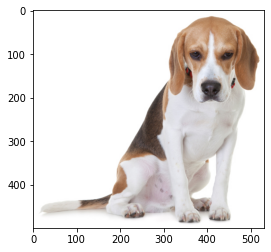

Beagle


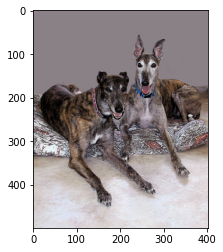

Greyhound


In [ ]:
predict_and_show('drive/MyDrive/dogImages/train/016.Beagle/Beagle_01182.jpg')
predict_and_show('drive/MyDrive/dogImages/train/081.Greyhound/Greyhound_05562.jpg')

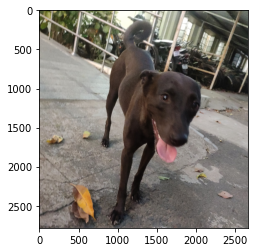

Cane corso


In [ ]:
predict_and_show('drive/MyDrive/IMG1_CROP.jpg')

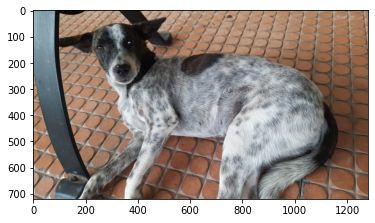

Australian cattle dog


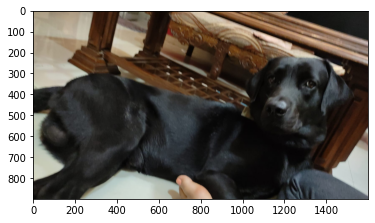

Flat-coated retriever


In [ ]:
predict_and_show('drive/MyDrive/1.jpeg')
predict_and_show('drive/MyDrive/2.jpeg')

In [ ]:
import torch
model_transfer.load_state_dict(torch.load('drive/MyDrive/model_transfer(2).pt'))


<All keys matched successfully>

In [ ]:
def predict_breed_transfer(img_path):
    global model_transfer
    image = Image.open(img_path).convert('RGB')
    image = data_transform(image).unsqueeze_(0)
    #if use_cuda:
    #    image = image.cuda()
    #    model_transfer = model_transfer.cuda()
    model_transfer.eval()
    idx = torch.argmax(model_transfer(image))
    return class_names[idx]

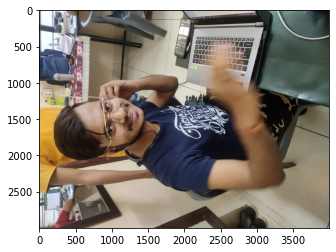

Dachshund


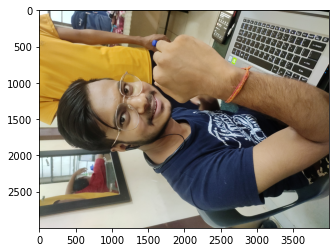

Italian greyhound


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

Image.LOAD_TRUNCATED_IMAGES = True
predict_and_show('drive/MyDrive/piyush1.jpg')
predict_and_show('drive/MyDrive/piyush2.jpg')
